#### Version's detail (pour qu'on s'y retrouve)
V2 : Able to parse over wiki page info and turn into csv doc. Strugles with special character and disambiguation pages. Citations counts are weird

V2.1 : Solved the special character problem

V2.2 : Cleaned the table and formated the date. Added a little hist to view page creation along time

V2.3 : Adding a function to pass the 500 treshhold in scraping articles title

V2.4 : Adding the scraping of the titles of sub- and sub-sub-sections

In [1]:
!pip install wikipedia

In [134]:
# This cell has to be run only the first time you use this notebook, as it will install the Python packages you need
# Note that this is NOT the proper way to install a Python package, but this will do the job
import sys
!{sys.executable} -m pip install -U setuptools
!{sys.executable} -m pip install pywikibot
!{sys.executable} -m pip install mwparserfromhell
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install -U nltk
!{sys.executable} -m pip install tqdm

^C
^C


In [135]:
!{sys.executable} -m pip install pyqt5
!{sys.executable} -m pip install pyqtwebengine

In [4]:
!{sys.executable} -m pip install pathlib
!{sys.executable} -m pip install ruamel-yaml

    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\aaugr\anaconda3\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\aaugr\\AppData\\Local\\Temp\\pip-install-a_u2043n\\pathlib_9cd39e7c106f4ee78683c1b8d02840a6\\setup.py'"'"'; __file__='"'"'C:\\Users\\aaugr\\AppData\\Local\\Temp\\pip-install-a_u2043n\\pathlib_9cd39e7c106f4ee78683c1b8d02840a6\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\aaugr\AppData\Local\Temp\pip-pip-egg-info-sz9iu6dx'
         cwd: C:\Users\aaugr\AppData\Local\Temp\pip-install-a_u2043n\pathlib_9cd39e7c106f4ee78683c1b8d02840a6\
    Complete output (19 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\


  Using cached pathlib-1.0.1.tar.gz (49 kB)
  Using cached pathlib-1.0.tar.gz (49 kB)
  Using cached pathlib-0.97.tar.gz (46 kB)
  Using cached pathlib-0.8.tar.gz (36 kB)
  Using cached pathlib-0.7.tar.gz (34 kB)
  Using cached pathlib-0.6.tar.gz (32 kB)
  Using cached pathlib-0.5.tar.gz (30 kB)
  Using cached pathlib-0.4.tar.gz (29 kB)
  Using cached pathlib-0.3.tar.gz (27 kB)
  Using cached pathlib-0.2.tar.gz (27 kB)
  Using cached pathlib-0.1.tar.gz (26 kB)



    Complete output (21 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "C:\Users\aaugr\AppData\Local\Temp\pip-install-a_u2043n\pathlib_54deb2cba4b141a2bd7c97b66e6f2843\setup.py", line 6, in <module>
        setup(
      File "C:\Users\aaugr\anaconda3\lib\site-packages\setuptools\_distutils\core.py", line 109, in setup
        _setup_distribution = dist = klass(attrs)
      File "C:\Users\aaugr\anaconda3\lib\site-packages\setuptools\dist.py", line 460, in __init__
        for ep in metadata.entry_points(group='distutils.setup_keywords'):
      File "C:\Users\aaugr\anaconda3\lib\site-packages\setuptools\_vendor\importlib_metadata\__init__.py", line 999, in entry_points
        return SelectableGroups.load(eps).select(**params)
      File "C:\Users\aaugr\anaconda3\lib\site-packages\setuptools\_vendor\importlib_metadata\__init__.py", line 449, in load
        ordered = sorted(eps, key=by_group)
      File "C:\Users\aaugr\anaconda3\lib\

In [2]:
# Import libraries
import PIL #library pour afficher des images à partir d'url
import wikipedia
import requests  
import re
from bs4 import BeautifulSoup
import pywikibot
import pandas as pd
import mwparserfromhell
import numpy as np
from scipy.spatial import distance
from nltk.tokenize import word_tokenize

from tqdm import tqdm
tqdm.pandas()
import time
import seaborn as sns

In [3]:
wikipedia.set_lang("en")  #We make our research in english

#### definition of the function for the CORPUS SELECTION

In [4]:
def function_to_get_all_the_bloody_titles(key_words):
    titles = []
    a = key_words.lower().replace(' ', '+')
    scraped_url = 'https://en.wikipedia.org/w/index.php?title=Special:Search&limit=50&offset=0&profile=default&search={}&ns0=1'.format(a)
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find('div', {'class' : 'results-info'})
    nbr_result = int(r.get('data-mw-num-results-total'))
    scraped_url2 = 'https://en.wikipedia.org/w/index.php?title=Special:Search&limit={page}&offset=0&profile=default&search={word}&ns0=1'.format(page = nbr_result, word = a)
    html_text2 = requests.get(scraped_url2).text
    soup2 = BeautifulSoup(html_text2, 'lxml')
    for interest in soup2.find_all('div', {'class' : 'mw-search-result-heading'}):
        titles.append(interest.find('a')['title'])
    return titles

In [5]:
def get_section_titles(page):
    section_tit = set()
    section_title = []
    scraped_url = wikipedia.page(page, auto_suggest = False).url
    html_text = requests.get(scraped_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    r = soup.find_all('h2') + soup.find_all('h3') + soup.find_all('h4')
    for i in r:
        if i.find('span', {'class' : 'mw-headline'}) != None :
            section_tit.add(i.find('span', {'class' : 'mw-headline'})['id'])
    for i in section_tit:
        section_title.append(i.replace('_', ' '))        
    return section_title

In [6]:
#We define a function to automatically set up a corpus of related articles
def corpus_selection(word_keys, number_of_results, key_for_section):
    corpus = []
    s_list = []
    search_list = function_to_get_all_the_bloody_titles(word_keys)[:number_of_results] #Select and put in a list number_of_results wikipedia articles related to word_keys
    a_list = []
    for i in search_list:
        try:
            wikipedia.summary(i, auto_suggest = False)
            a_list.append(i)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                wikipedia.summary(i, auto_suggest = False)
                a_list.append(i)
            except wikipedia.exceptions.PageError as e:
                pass
    for j in a_list:
        if key_for_section in j.lower(): #Among these articles, select the ones whose title contains key_for_selection for the corpus
            corpus.append(j)
        else:
            s_list.append(j) #Put the rest of the articles in a list
    for k in s_list:
        try :
            sec_tit = get_section_titles(k)
        except wikipedia.exceptions.DisambiguationError as e:
            pass
        except wikipedia.exceptions.PageError as e:
            try:
                sec_tit = get_section_titles(k)
            except wikipedia.exceptions.PageError as e:
                pass
        for l in sec_tit:
            if key_for_section.lower() in l.lower() and k not in corpus:
                corpus.append(k)
    return corpus

## TO LAUNCH THE CORPUS SELECTION

In [8]:
%%time
search_list = corpus_selection("effect of climate change", 1, 'climate change')

Wall time: 18.2 s


In [244]:
#function_to_get_all_the_bloody_titles("World Scientists' Warning to Humanity")
get_section_titles("World Scientists' Warning to Humanity")

{'Citations', 'First_publication', 'External_links', 'Excerpts_and_notes', 'Second_Notice', 'See_also', 'Bibliography', '2019_warning_on_climate_change_and_2021_update', 'References'}


['Citations',
 'First publication',
 'External links',
 'Excerpts and notes',
 'Second Notice',
 'See also',
 'Bibliography',
 '2019 warning on climate change and 2021 update',
 'References']

In [251]:
len(search_list)#gives us the number of article in our corpus

1

In [252]:
set(search_list)#gives us the title of our corpus

{"World Scientists' Warning to Humanity"}

#### definition of the function for the extraction of citation

In [9]:
# Some additional functions
def get_ids_from_ref(ref):
    d = dict(re.findall(r'(doi|pmc|pmid)\s?[=\|]\s?([^|\s}]*)', ref))
    ids = {k: v for k, v in d.items() if v}
    return ids

        
def get_citations(wikicode):
    citations = [c.lower() for c in re.findall(r'<ref(?:\s(?:[^\/]*?))?>(.*?)<\/ref>', wikicode) + re.findall(r'({{(?:cite|vcite2|Cite)\s[^}]*}})', wikicode)]
    s = set()
    
    i=0
    for c in citations:
        i+=1
        #print("beginning of c",i,c,"end of c")
        s.update(c.split('<br/>'))
        
    ds = pd.DataFrame(s, columns=['ref'])
    
    #print(list(ds['ref']))
    ds['ids'] = ds['ref'].apply(get_ids_from_ref)
    ds['pmid'] = ds['ids'].apply(lambda x: x.get('pmid', None))
    ds['doi'] = ds['ids'].apply(lambda x: x.get('doi', None))
    ds['pmc'] = ds['ids'].apply(lambda x: x.get('pmc', None))
    ds["available"]=ds["ids"]== {}
    #print(ds["available"])
    dsbis= ds[(~ds['pmid'].isnull())|~(ds['doi'].isnull())|~(ds['pmc'].isnull())]
    
    ds = ds[(~ds['pmid'].duplicated()) | (ds['pmid'].isnull())]
    ds = ds[(~ds['doi'].duplicated()) | (ds['doi'].isnull())]
    ds = ds[(~ds['pmc'].duplicated()) | (ds['pmc'].isnull())]
    
    
    dg=ds.loc[ds["available"]==True,["ref"]]
    dg['idsIPCC']=dg['ref'].apply(get_IPCC_from_ref)
    dg['IPCC'] = dg['idsIPCC'].apply(lambda x: x.get('IPCC', None))
    dg["available"]= dg["idsIPCC"]=={}
    
    dorg=dg.loc[dg["available"]==True,["ref"]]
    #dg.groupby('User_ID')['Datetime'].apply(lambda g: len(g)>1)
    #dg = pd.DataFrame(s, columns=['ref'])
    dorg['ids'] = dorg['ref'].apply(get_org_from_ref)
    dorg['org'] = dorg['ids'].apply(lambda x: x.get('org', None))
    dorg["available"]= dorg["ids"]=={}
    
    dgov=dorg.loc[dorg["available"]==True,["ref"]]
    #dgov.drop(dgov[dgov['available'] == False].index, inplace=True)
    
    dgov['ids']=dgov['ref'].apply(get_gov_from_ref)
    dgov['gov'] = dgov['ids'].apply(lambda x: x.get('gov', None))
    dgov["available"]= dgov["ids"]=={}
    
    dguard=dgov.loc[dgov["available"]==True,["ref"]]
    dguard['ids']=dguard['ref'].apply(get_guardian_from_ref)
    dguard['guard'] = dguard['ids'].apply(lambda x: x.get('guard', None))
    dguard["available"]= dguard["ids"]=={}
    
    dcom=dguard.loc[dguard["available"]==True,["ref"]]
    dcom['ids']=dcom['ref'].apply(get_com_from_ref)
    dcom['com'] = dcom['ids'].apply(lambda x: x.get('com', None))
    dcom["available"]= dcom["ids"]=={}

    
    dipbes=dcom.loc[dcom["available"]==True,["ref"]]
    dipbes['ids']=dipbes['ref'].apply(get_ipbes_from_ref)
    dipbes['ipbes'] = dipbes['ids'].apply(lambda x: x.get('ipbes', None))
    dipbes["available"]= dipbes["ids"]=={}
    
    drest = dcom.loc[dcom["available"]==True,["ref"]]
    
    dgbisgov=dgov[(~dgov['gov'].isnull())]
    #dg = dg[(~dg['org'].duplicated()) | (dg['org'].isnull())]
    
    dgbisorg=dorg[(~dorg['org'].isnull())]
    #dg = dg[(~dg['gov'].duplicated()) | (dg['gov'].isnull())]
    
    dgbisIPCC=dg[(~dg['IPCC'].isnull())]
    #dg = dg[(~dg['IPCC'].duplicated()) | (dg['IPCC'].isnull())]
    
    dgbiscom=dcom[(~dcom['com'].isnull())]
    
    dbisguard = dguard[(~dguard['guard'].isnull())]
    dgbisipbes=dipbes[(~dipbes['ipbes'].isnull())]
    
    return {'Ref count': ds.shape[0], 'nb_journal_citations': ds[(~ds['pmid'].isnull()) | (~ds['doi'].isnull()) | (~ds['pmc'].isnull())].shape[0],"citationjournal":list(list(dsbis["doi"])+list(dsbis["pmid"])+list(dsbis["pmc"])),"citations.org": dorg[(~dorg['org'].isnull())].shape[0],"citations.gov": dgov[(~dgov['gov'].isnull())].shape[0],"citationgovtext":list(dgbisgov['gov']),"citationorgtext":list(dgbisorg['org']),"citationsIPCC.ch": dg[(~dg['IPCC'].isnull())].shape[0],"citationIPCCtext":list(dgbisIPCC['IPCC']),"citationautre":list(drest["ref"]),"citationcomtext":list(dgbiscom['com']),"citations.com": dcom[(~dcom['com'].isnull())].shape[0],"citationipbestext":list(dgbisipbes['ipbes']),"citationsipbes": dipbes[(~dipbes['ipbes'].isnull())].shape[0],"citationguardian": dguard[(~dguard['guard'].isnull())].shape[0]}

In [10]:

def get_org_from_ref(ref):  
    citationorg=list(set(re.findall(r"((?:[(\.)(\-)\w+\d+]*)\.org)", ref, flags=re.IGNORECASE)))
    
    if 'web.archive.org' in citationorg:
        if len(citationorg)>1:
            citationorg.remove('web.archive.org')
        else:
            citationorg=[]
    if 'doi.org' in citationorg:
        if len(citationorg)!=1:
            citationorg.remove('doi.org')
        else:
            citationorg=[]
    if citationorg !=None and citationorg !=[]:
        
        #citationorg= [tuple(["org"]+citationorg)]
        g = {"org":citationorg}
        org = {k: v for k, v in g.items() if v}
        return org
    else:
        return{}

In [11]:
def get_gov_from_ref(ref):
        citationgov=list(set(re.findall(r"((?:[(\.)(\-)\w+\d+]*)\.gov)", ref, flags=re.IGNORECASE)))
        if citationgov !=None and citationgov !=[]:
            g= {"gov" : citationgov}          
            gov = {k: v for k, v in g.items() if v}
            return gov
        else:
            return{}
def get_com_from_ref(ref):
        citationgov=list(set(re.findall(r"((?:[(\.)(\-)\w+\d+]*)\.com)", ref, flags=re.IGNORECASE)))
        if citationgov !=None and citationgov !=[]:
            g= {"com" : citationgov}          
            com = {k: v for k, v in g.items() if v}
            return com
        else:
            return{}


In [12]:
def get_IPCC_from_ref(ref):
        citationIPCC=list(set(re.findall(r"((?:[(\.)(\-)\w+\d+]*)ipcc)", ref, flags=re.IGNORECASE)))
        if citationIPCC !=None and citationIPCC !=[]:
            g= {"IPCC" : citationIPCC}          
            IPCC = {k: v for k, v in g.items() if v}
            return IPCC
        else:
            return{}

def get_ipbes_from_ref(ref):
        citationIPCC=list(set(re.findall(r"((?:[(\.)(\-)\w+\d+]*)ipbes)", ref, flags=re.IGNORECASE)))
        if citationIPCC !=None and citationIPCC !=[]:
            g= {"ipbes" : citationIPCC}          
            ipbes = {k: v for k, v in g.items() if v}
            return ipbes
        else:
            return{}
def get_guardian_from_ref(ref):
        citationIPCC=list(set(re.findall(r"((?:[(\.)(\-)\w+\d+]*)guardian)", ref, flags=re.IGNORECASE)))
        if citationIPCC !=None and citationIPCC !=[]:
            g= {"guard" : citationIPCC}          
            guard = {k: v for k, v in g.items() if v}
            return guard
        else:
            return{}

#### creation du dataframe

In [13]:
tableau =[] #creation of a list that will contain a dictionnary for each page with the information
for i in range(len(search_list)):
    page =wikipedia.page(search_list[i], auto_suggest = False)
    page_title =page.title #give the clean name of the page
    page_url=page.url #give the url of the page
    site = pywikibot.Site("en", "wikipedia")
    page = pywikibot.Page(site, page_title)
    infopage ={'Name only' : page_title, 'page url' :page_url,'text':page.text}
    tableau.append(infopage)
df=pd.DataFrame.from_dict(tableau)


#### extract from text document the wiki code

In [16]:
# %load '2008.txt'
def text_import(year):
    filename =str(year) +".txt"
    dataframe_name = pd.read_csv(filename, sep = '\t')
    return str(dataframe_name)


In [17]:
 #creation of a list that will contain a dictionnary for each page with the information
for i in range(2006,2022):
    page =wikipedia.page(search_list[0], auto_suggest = False)
    page_title =i #give the clean name of the page
    page_url= "https://en.wikipedia.org/w/index.php?title=Effects_of_climate_change&oldid=298597212" #give the url of the page
    text=text_import(str(i))
    infopage ={'Name only' : page_title, 'page url' :page_url,'text':text}
    tableau.append(infopage)
    df=pd.DataFrame.from_dict(tableau)

## Get the citations

In [14]:
print('Getting citations')
df['citations'] = df['text'].progress_apply(lambda x: get_citations(x))
#print("getting journal names")
#df["journaux"] = df['text'].progress_apply(lambda x: trijournaux(x))
print("getting the number of references")
df['Ref count'] = df['citations'].progress_apply(lambda x: x['Ref count'])
print("getting the number of scientific citations")
df['nb_journal_citations'] = df['citations'].progress_apply(lambda x: x['nb_journal_citations'])
df["journalcitation"] = df['citations'].progress_apply(lambda x: x['citationjournal'])

print("getting the number of .org citation")
df["citation org"]=df['citations'].progress_apply(lambda x: x['citations.org'])
df["citationorgtext"]=df['citations'].progress_apply(lambda x: x["citationorgtext"])

print("getting the number of .gov citation")
df["citation gov"]=df['citations'].progress_apply(lambda x: x["citations.gov"])
df["citationgovtext"]=df['citations'].progress_apply(lambda x: x["citationgovtext"])

print("getting the number of IPCC citation")
df["citation IPCC"]=df['citations'].progress_apply(lambda x: x["citationsIPCC.ch"])
df["citationIPCCtext"]=df['citations'].progress_apply(lambda x: x["citationIPCCtext"])

print("getting the .com citations")
df["citation.com"]=df['citations'].progress_apply(lambda x: x["citations.com"])
df["citationcomtext"]=df['citations'].progress_apply(lambda x: x["citationcomtext"])


print("getting the ipbes citation")
df["citationipbes"]=df['citations'].progress_apply(lambda x: x["citationsipbes"])

print("getting the guardian citation")
df["citationguardian"]=df['citations'].progress_apply(lambda x: x["citationguardian"])

print("getting the other citation")
df["citationautre"]=df['citations'].progress_apply(lambda x: x["citationautre"])



for i in df.index:
    df.loc[i,'Sci count']=df.loc[i,'nb_journal_citations']/df.loc[i,'Ref count']
    df.loc[i,'IPCC count']=df.loc[i,'citation IPCC']/df.loc[i,'Ref count']
    df.loc[i,'percentage of official sources']=(df.loc[i,'nb_journal_citations']+ df.loc[i,'citation gov']+ df.loc[i,'citation org']+df.loc[i,'citation IPCC']+df.loc[i,'citationipbes'])/df.loc[i,'Ref count']

print('Done!')
df.head()

Getting citations


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


getting the number of references


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


getting the number of scientific citations


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


getting the number of .org citation


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


getting the number of .gov citation


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


getting the number of IPCC citation


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


getting the .com citations


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


getting the ipbes citation


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


getting the guardian citation


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


getting the other citation


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Done!


,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,citation org,citationorgtext,citation gov,...,citation IPCC,citationIPCCtext,citation.com,citationcomtext,citationipbes,citationguardian,citationautre,Sci count,IPCC count,percentage of official sources
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 251, 'nb_journal_citations': 57,...",251,57,"[10.1038/ngeo420, 10.1038/s41467-019-12808-z, ...",27,"[[www.nrdc.org], [journals.plos.org], [www.wef...",23,...,95,"[[ipcc], [ipcc, archive.ipcc], [ipcc, archive....",23,"[[airportbusiness.com, www.airportbusiness.com...",2,10,[environmental migrants: up to 1 billion by 20...,0.227092,0.378486,0.812749


In [15]:
df.loc[:,["Name only","Ref count","citation IPCC","percentage of official sources","IPCC count","citationipbes","citationguardian"]]


,Name only,Ref count,citation IPCC,percentage of official sources,IPCC count,citationipbes,citationguardian
0,Effects of climate change,251,95,0.812749,0.378486,2,10


In [16]:
def jsp(j,dicorg):
    if "www." in j:
        j=j.replace('www.','')
        if "nasa.gov" in j:
            j="nasa.gov"
        if j in dicorg:
            dicorg[j]+=1
        else:
            dicorg[j]=1
    return dicorg

In [17]:
def sortcitation(d):
    dicorg={}
    for x in d:
        listcitationorg=list(x)
        j=x[0]
        if type(j)==type("r"):
            dicorg=jsp(j,dicorg)
        else :
            for i in x:
                j=i[0]
                dicorg=jsp(j,dicorg)
                
        dico=dicorg
    #with all dictionary keys with values.
    dforg=pd.DataFrame(list(dicorg.items()),columns=['name of site','numbertimescited'])
    dforg.sort_values(by=['numbertimescited'], inplace=True, ascending=False)
    return dforg,dico
    

In [18]:
d=list(df.loc[0,"citationorgtext"])
dforg,dico=sortcitation(d)
dforg

,name of site,numbertimescited
2,carbonbrief.org,3
0,nrdc.org,2
1,weforum.org,1
3,sciencenews.org,1
4,unhcr.org,1
5,internal-displacement.org,1
6,ucsusa.org,1
7,climatecommunication.org,1
8,texastribune.org,1
9,npr.org,1


In [19]:
dfgov,j=sortcitation(df.loc[0,"citationgovtext"])
dfgov

,name of site,numbertimescited
2,ncdc.noaa.gov,3
0,climatewatch.noaa.gov,2
3,arctic.noaa.gov,2
1,nasa.gov,1
4,climatescience.gov,1
5,gfdl.noaa.gov,1
6,climate.gov,1


In [21]:
dcom,bl=sortcitation(df.loc[0,["citationcomtext"]])


In [25]:
df.loc[0,["Name only"]]=2022
df

,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,citation org,citationorgtext,citation gov,...,citation IPCC,citationIPCCtext,citation.com,citationcomtext,citationipbes,citationguardian,citationautre,Sci count,IPCC count,percentage of official sources
0,2022,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 251, 'nb_journal_citations': 57,...",251,57,"[10.1088/1748-9326/abb1f2, 10.1038/nclimate297...",27,"[[www.carbonbrief.org], [documents1.worldbank....",23,...,95,"[[www.ipcc, ipcc], [ipcc], [archive.ipcc, ipcc...",23,"[[scienmag.com], [apnews.com], [www.nationalge...",2,10,[{{cite web |title=who &#124; the global burde...,0.227092,0.378486,0.812749
1,2006,https://en.wikipedia.org/w/index.php?title=Eff...,[[Image:Recent Sea Level Rise.png|right|thum...,"{'Ref count': 0, 'nb_journal_citations': 0, 'c...",0,0,[],0,[],0,...,0,[],0,[],0,0,[],NaN,NaN,NaN
2,2007,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{See|Global warmin...,"{'Ref count': 110, 'nb_journal_citations': 6, ...",110,6,"[10.1029/2006gl028905, 10.1073/pnas.052131199,...",20,"[[lnweb18.worldbank.org], [www.animana.org], [...",5,...,9,"[[ipcc], [ipcc], [ipcc], [ipcc], [ipcc], [www....",25,"[[www.news.com, news.com], [www.cnn.com], [www...",0,8,[http://iis-db.stanford.edu/pubs/20115/naturef...,0.054545,0.081818,0.363636
3,2008,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{pp-semi-protected...,"{'Ref count': 165, 'nb_journal_citations': 34,...",165,34,"[10.1038/nature01333, 10.1175/jcli3800.1, 10.1...",28,"[[www.realclimate.org], [royalsociety.org], [w...",11,...,11,"[[www.ipcc], [ipcc], [www.ipcc], [www.ipcc], [...",30,"[[www.insurancejournal.com], [www.sciencedirec...",0,11,[[http://news.bbc.co.uk/1/hi/world/7284196.stm...,0.206061,0.066667,0.509091
4,2009,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{Pp-semi-protected...,"{'Ref count': 195, 'nb_journal_citations': 53,...",195,53,"[10.1086/419764, 10.1641/b570306, 10.1175/jcli...",34,"[[www.realclimate.org], [royalsociety.org], [w...",15,...,10,"[[ipcc], [www.ipcc], [dn14634-sea-level-rises-...",29,"[[www.nature.com], [www.insurancejournal.com],...",0,8,[ bbc news: [http://news.bbc.co.uk/2/hi/scienc...,0.271795,0.051282,0.574359
5,2010,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{Pp-semi-protected...,"{'Ref count': 68, 'nb_journal_citations': 9, '...",68,9,"[10.1073/pnas.0703073104, 10.1038/nature09098,...",0,[],2,...,50,"[[ipcc], [www.ipcc, ipcc], [www.ipcc, ipcc], [...",1,[[www.economist.com]],0,0,[{{cite news |url=http://www.independent.co.uk...,0.132353,0.735294,0.897059
6,2011,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{Pp-semi-protected...,"{'Ref count': 150, 'nb_journal_citations': 8, ...",150,8,"[10.1038/ngeo420, 10.2277/0521568544, 10.1073/...",1,[[americasclimatechoices.org]],13,...,116,"[[www.ipcc, ipcc], [www.ipcc, ipcc], [www.ipcc...",1,[[www.economist.com]],0,0,[ {{cite book | year = 2008 | chapter = introd...,0.053333,0.773333,0.920000
7,2012,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{about|(primarily)...,"{'Ref count': 177, 'nb_journal_citations': 15,...",177,15,"[10.1007/bf00312320, 10.1073/pnas.0812355106, ...",3,"[[www.fao.org], [siteresources.worldbank.org],...",15,...,112,"[[www.ipcc, ipcc], [www.ipcc, ipcc], [ipcc], [...",4,"[[www.chemistry-dictionary.com], [www.economis...",0,0,[{{cite book|last=mcguire|first=bill|title=rag...,0.084746,0.632768,0.819209
8,2013,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{about|(primarily)...,"{'Ref count': 205, 'nb_journal_citations': 14,...",205,14,"[10.1073/pnas.0812721106, 10.1007/bf00312320, ...",5,"[[www.ucsusa.org], [www.unep.org], [www.fao.or...",33,...,116,"[[www.ipcc, ipcc], [www.ipcc, ipcc], [www.ipcc...",8,"[[www.chemistry

In [180]:
del df['citations']

In [103]:
del df['text']

In [ ]:
def plotevolcit(org):
    

In [26]:
df.set_index("Name only",inplace=True)
df

,page url,text,citations,Ref count,nb_journal_citations,journalcitation,citation org,citationorgtext,citation gov,citationgovtext,citation IPCC,citationIPCCtext,citation.com,citationcomtext,citationipbes,citationguardian,citationautre,Sci count,IPCC count,percentage of official sources
Name only,,,,,,,,,,,,,,,,,,,,
2022,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 251, 'nb_journal_citations': 57,...",251,57,"[10.1088/1748-9326/abb1f2, 10.1038/nclimate297...",27,"[[www.carbonbrief.org], [documents1.worldbank....",23,"[[science2017.globalchange.gov], [www.climatew...",95,"[[www.ipcc, ipcc], [ipcc], [archive.ipcc, ipcc...",23,"[[scienmag.com], [apnews.com], [www.nationalge...",2,10,[{{cite web |title=who &#124; the global burde...,0.227092,0.378486,0.812749
2006,https://en.wikipedia.org/w/index.php?title=Eff...,[[Image:Recent Sea Level Rise.png|right|thum...,"{'Ref count': 0, 'nb_journal_citations': 0, 'c...",0,0,[],0,[],0,[],0,[],0,[],0,0,[],NaN,NaN,NaN
2007,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{See|Global warmin...,"{'Ref count': 110, 'nb_journal_citations': 6, ...",110,6,"[10.1029/2006gl028905, 10.1073/pnas.052131199,...",20,"[[lnweb18.worldbank.org], [www.animana.org], [...",5,"[[www.epa.gov], [www2.metoffice.gov], [www.usg...",9,"[[ipcc], [ipcc], [ipcc], [ipcc], [ipcc], [www....",25,"[[www.news.com, news.com], [www.cnn.com], [www...",0,8,[http://iis-db.stanford.edu/pubs/20115/naturef...,0.054545,0.081818,0.363636
2008,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{pp-semi-protected...,"{'Ref count': 165, 'nb_journal_citations': 34,...",165,34,"[10.1038/nature01333, 10.1175/jcli3800.1, 10.1...",28,"[[www.realclimate.org], [royalsociety.org], [w...",11,"[[earthobservatory.nasa.gov], [www.epa.gov], [...",11,"[[www.ipcc], [ipcc], [www.ipcc], [www.ipcc], [...",30,"[[www.insurancejournal.com], [www.sciencedirec...",0,11,[[http://news.bbc.co.uk/1/hi/world/7284196.stm...,0.206061,0.066667,0.509091
2009,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{Pp-semi-protected...,"{'Ref count': 195, 'nb_journal_citations': 53,...",195,53,"[10.1086/419764, 10.1641/b570306, 10.1175/jcli...",34,"[[www.realclimate.org], [royalsociety.org], [w...",15,"[[earthobservatory.nasa.gov], [www.cdc.gov], [...",10,"[[ipcc], [www.ipcc], [dn14634-sea-level-rises-...",29,"[[www.nature.com], [www.insurancejournal.com],...",0,8,[ bbc news: [http://news.bbc.co.uk/2/hi/scienc...,0.271795,0.051282,0.574359
2010,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{Pp-semi-protected...,"{'Ref count': 68, 'nb_journal_citations': 9, '...",68,9,"[10.1073/pnas.0703073104, 10.1038/nature09098,...",0,[],2,"[[www.noaanews.noaa.gov], [newscenter.lbl.gov]]",50,"[[ipcc], [www.ipcc, ipcc], [www.ipcc, ipcc], [...",1,[[www.economist.com]],0,0,[{{cite news |url=http://www.independent.co.uk...,0.132353,0.735294,0.897059
2011,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{Pp-semi-protected...,"{'Ref count': 150, 'nb_journal_citations': 8, ...",150,8,"[10.1038/ngeo420, 10.2277/0521568544, 10.1073/...",1,[[americasclimatechoices.org]],13,"[[downloads.globalchange.gov], [www.globalchan...",116,"[[www.ipcc, ipcc], [www.ipcc, ipcc], [www.ipcc...",1,[[www.economist.com]],0,0,[ {{cite book | year = 2008 | chapter = introd...,0.053333,0.773333,0.920000
2012,https://en.wikipedia.org/w/index.php?title=Eff...,Empty DataFrame\nColumns: [{{about|(primarily)...,"{'Ref count': 177, 'nb_journal_citations': 15,...",177,15,"[10.1007/bf00312320, 10.1073/pnas.0812355106, ...",3,"[[www.fao.org], [siteresources.worldbank.org],...",15,"[[www.globalchange.gov], [www.noaanews.noaa.go...",112,"[[www.ipcc, ipcc], [www.ipcc, ipcc], [ipcc], [...",4,"[[www.chemistry-dictionary.com], [www.economis...",0,0,[{{cite book|last=mcguire|first=bill|title=rag...,0.084746,0.632768,0.819209
2013

In [66]:
import matplotlib.pyplot as plt

In [84]:
def plol_evol_cit(nb_cit,text_cit):   
    dorg=pd.DataFrame()

    for i in range(2007,2022):
        if int(nb_cit)!=0:
            dforg,dicorg=sortcitation(text_cit)
            for j in dicorg.keys():
                dorg.loc[i,[j]]= dicorg[j]

    dorg=dorg.fillna(0)            

    dorg.loc["total",:]=dorg.sum(0)
    dorg["somme"]=dorg.sum(1)
    new_df = dorg.loc[:, dorg.loc["total"]>1]
    dorg = new_df.drop('total')


    sns.lineplot(data=dorg["somme"])
plol_evol_cit(df.loc[i,["citationorg"]],df.loc[i,["citationorgtext"]])
#dorg.to_csv('climatechangehistoricdorg.csv')

KeyError: "None of [Index(['citationorg'], dtype='object')] are in the [index]"

In [22]:
df.to_csv('climatechange.csv')
dforg.to_csv('climatechangeorg.csv')
dfgov.to_csv('climatechangegov.csv')
dcom.to_csv('climatechangecom.csv')

In [317]:
titlelist=df["Name only"].tolist() #make a list will all titles
#We need to recreate the wiki url, first step is to get rid of blanks
titleunderscore = [sub.replace(' ', '_') for sub in titlelist]

AttributeError: 'int' object has no attribute 'replace'

In [318]:
#We finally get from the original url to the pageinfo url
urlmodifié = ['https://en.wikipedia.org/w/index.php?title=' + i +'&action=info' for i in titleunderscore]

print(urlmodifié)

['https://en.wikipedia.org/w/index.php?title=Effects_of_climate_change&action=info']


In [319]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import pandas as pd


In [173]:
#Cell to scrap infos from "page info" section (2 to scrap the third table of the page)
doblist=[]
creatorlist=[]
totaledits=[]
recentedits=[]
pageid=[]
pagelenght=[]
editprotection=[]
recentpageviews=[]

for i in tqdm(urlmodifié) :
    source = requests.get(i)
    soup = BeautifulSoup(source.text, 'lxml')
    #soup = BeautifulSoup(source, "html.parser", from_encoding="utf-8")
    alltables=soup.findAll('table', {"class": "wikitable mw-page-info"})
    tableau_html_liste=pd.read_html(str(alltables)) #We get it as a list   
    df_pageinfo2=pd.DataFrame(tableau_html_liste[2]) #And make it a df 
    #The number between brackets corresponds to the number of the table according to its order on the html page
    creatorlist += [df_pageinfo2.iat[0, 1]]
    doblist += [df_pageinfo2.iat[1, 1]]
    totaledits += [df_pageinfo2.iat[4, 1]]
    recentedits += [df_pageinfo2.iat[5, 1]]
    
    
    #Scrap of the first table of the page (0)
    df_pageinfo0=pd.DataFrame(tableau_html_liste[0])
    pagelenght += [df_pageinfo0.iat[2, 1]]
    pageid += [df_pageinfo0.iat[3, 1]]
    #recentpageviews += [df_pageinfo0.loc['Page views in the past 30 days']]
            
    
    #Scrap of the second table of the page (1)
    df_pageinfo1=pd.DataFrame(tableau_html_liste[1])
    editprotection += [df_pageinfo1.iat[1, 1]]
  

    

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


In [ ]:
#df_pageinfo0
#df_pageinfo0.loc['Page ID']

In [174]:
#Cell to add the new lists as new columns of the df
df["Page id"]=pageid
df["Edit protection"]=editprotection
df["Page lenght (Bytes)"]=pagelenght
df["DOB"]=doblist
df["Creator"]=creatorlist
df["Total edits"]=totaledits
df["Recent edits"]=recentedits
df.head()

,Name only,page url,text,citations,Ref count,nb_journal_citations,journalcitation,citation org,citationorgtext,citation gov,...,citationIPCCtext,Sci count,percentage of official sources,Page id,Edit protection,Page lenght (Bytes),DOB,Creator,Total edits,Recent edits
0,Effects of climate change,https://en.wikipedia.org/wiki/Effects_of_clima...,{{short description|Effects created by climate...,"{'Ref count': 251, 'nb_journal_citations': 57,...",251,57,"[10.1038/d41586-019-03595-0, 10.1007/s10584-01...",34,"[[www.nrdc.org], [www.climatechange2013.org], ...",26,...,"[[www.ipcc.ch], [www.ipcc.ch], [www.ipcc.ch], ...",0.227092,0.681275,2119174,Require autoconfirmed or confirmed access (no ...,185781,"15:09, 26 June 2005",Rd232 (talk | contribs),5530,13


In [186]:
print("ref count",df["Ref count"])
print("unique",df['unique_references_xtools'])
print((int(df['unique_references_xtools'])-int(df["Ref count"])))

ref count 0    251
Name: Ref count, dtype: int64
unique 0    255
Name: unique_references_xtools, dtype: int64
4


In [176]:
#Cleaning the table

#Getting rid of the time
df["DOB"]= df["DOB"].str.slice(7,100,1) 
#peutêtre qu'on pourrait mettre comme end point la len de la string

#Format the date
df["Formated DOB"]=pd.to_datetime(df["DOB"], format='%d %B %Y')
df["Year_month"]= pd.to_datetime(df['DOB']).dt.to_period('M')

#Getting the year
df['Year'] = pd.DatetimeIndex(df['DOB']).year

#Cleaning the creator 
df["Creator"]= df["Creator"].str.replace(r"\(.*\)",'', regex=True)

In [177]:
df.to_csv('Theclimatechange.csv')

matplotlib.axes._subplots.AxesSubplot

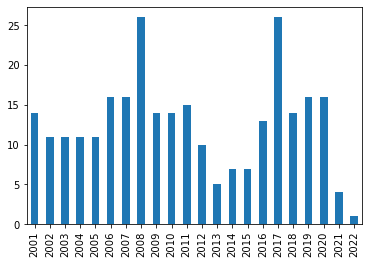

In [ ]:
plothist=df["Year"].value_counts().sort_index().plot(kind="bar")

type(plothist)

#### Next is xtools part, ignore it 

In [183]:
urlxtools_prose = ["https://xtools.wmflabs.org/api/page/prose/en.wikipedia.org/" + i for i in titleunderscore]
urlxtools_info = ["https://xtools.wmflabs.org/api/page/articleinfo/en.wikipedia.org/" + i for i in titleunderscore]

for i in titleunderscore:
    urlxtools_edits=["https://xtools.wmflabs.org/api/metrics/edits/per-page/en.wikipedia.org/" + i + "/all-editor-types/daily/20010101/20220101"]

In [184]:
import json
prose_dic=[]
unique_references_xtools=[]
key = "unique_references"
for i in tqdm(urlxtools_prose) :
    prose_str=requests.get(i).text
    prose_dic = json.loads(prose_str)
    
    unique_references_xtools.append(prose_dic[key])


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


In [185]:
df['unique_references_xtools']=unique_references_xtools

In [ ]:
df.head()
df.to_csv('Corpus_CC_V3.csv')

In [ ]:
for i in urlxtools_edits:
    print(requests.get(i).text)


<!DOCTYPE html>
<html lang="en">
<head>
    <title>
        Error - XTools
    </title>

        <script type="text/javascript">
        xtBaseUrl = "/";

                i18nLang = "en";
        i18nPaths = {};
                    i18nPaths["en"] = "/i18n/en.json";
                    i18nPaths["en"] = "/i18n/en.json";
        
        i18nRTL = false;
    </script>

            <script type="text/javascript" src="https://tools-static.wmflabs.org/cdnjs/ajax/libs/jquery/3.3.1/jquery.min.js"></script>
        <script type="text/javascript" src="/assets/app.753b88d7.js"></script>
        <script type="text/javascript" src="https://tools-static.wmflabs.org/cdnjs/ajax/libs/twitter-bootstrap/3.3.7/js/bootstrap.min.js"></script>
        <script src="https://tools-static.wmflabs.org/cdnjs/ajax/libs/select2/4.0.5/js/select2.full.min.js"></script>
                <link rel="stylesheet" type="text/css" media="screen" href="https://tools-static.wmflabs.org/cdnjs/ajax/libs/twitter-bootstrap/3.3.7

Trying to extract for weird formatted type but only one in our corpus => not necessary to do a program

In [289]:
for i in df["Ref count"]:
    if i==0:
        
            page = wikipedia.page(df.loc[i, "Name only"])
            print(df.loc[i, "Name only"])
            
            soup = BeautifulSoup(page.html(), 'html.parser')
            citations =soup.find_all('cite', {'class':"citation cs2"})
            for c in citations:
                test= get_ids_from_ref(str(c))

World Scientists' Warning to Humanity
{}
{}
{}
{}
{}
{}
{}
{}
